In [19]:
from __future__ import print_function
from Decoder import Decoder
from Encoder import Encoder
from VectorQuantizer import VectorQuantizer
from Residual import Residual 
from VQModel import VQModel

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import os

from six.moves import xrange
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
])

# Load your custom dataset
training_data = datasets.ImageFolder(root="data/images", transform=transform)
validation_data = datasets.ImageFolder(root="data/validation_images", transform=transform)

# Check the dataset size
print(f"Number of training samples: {len(training_data)}")

Number of training samples: 10000


In [7]:
batch_size = 10
num_training_updates = 2000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25
decay = 0.99
learning_rate = 1e-3


training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=1,
                               shuffle=True,
                               pin_memory=True)

In [8]:
model = VQModel(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / 0.04
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        torch.save(model.state_dict(), f"Models/Model_{i+1}")
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [22]:
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1836009..1.3960931].


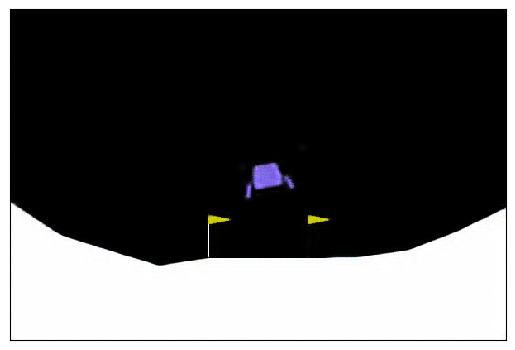

In [25]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

show(make_grid(valid_reconstructions.cpu().data)+0.5)

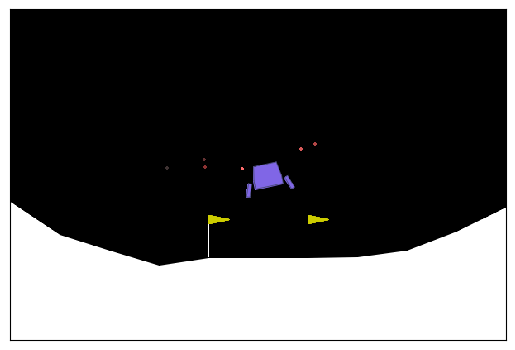

In [24]:
show(make_grid(valid_originals.cpu()+0.5))

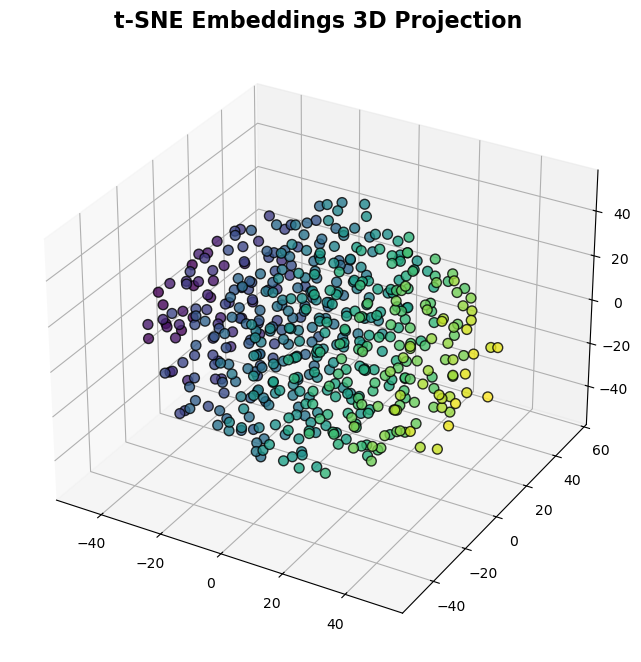

In [17]:
# Initialize the t-SNE model for 3D
tsne_model = TSNE(n_components=3, perplexity=30, metric='cosine', random_state=42)

# Perform the transformation
embedding_data = model._vq_vae._embedding.weight.data.cpu().numpy()
proj = tsne_model.fit_transform(embedding_data)

# Create a colormap based on a property of the data (e.g., first dimension)
colors = proj[:, 0]
norm_colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    proj[:, 0], proj[:, 1], proj[:, 2],
    c=norm_colors,  
    cmap='viridis',  
    s=50,  # Point size
    alpha=0.8,  # Slight transparency for depth perception
    edgecolors='k'  # Black edge for better contrast
)
# Add labels and title
ax.set_title("t-SNE Embeddings 3D Projection", fontsize=16, weight='bold')
# Add interactive rotation
plt.show()

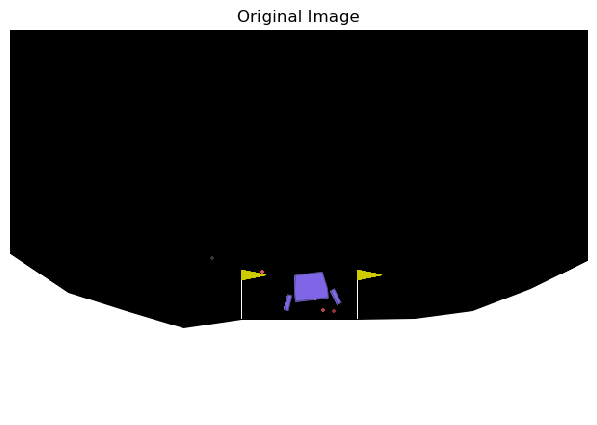

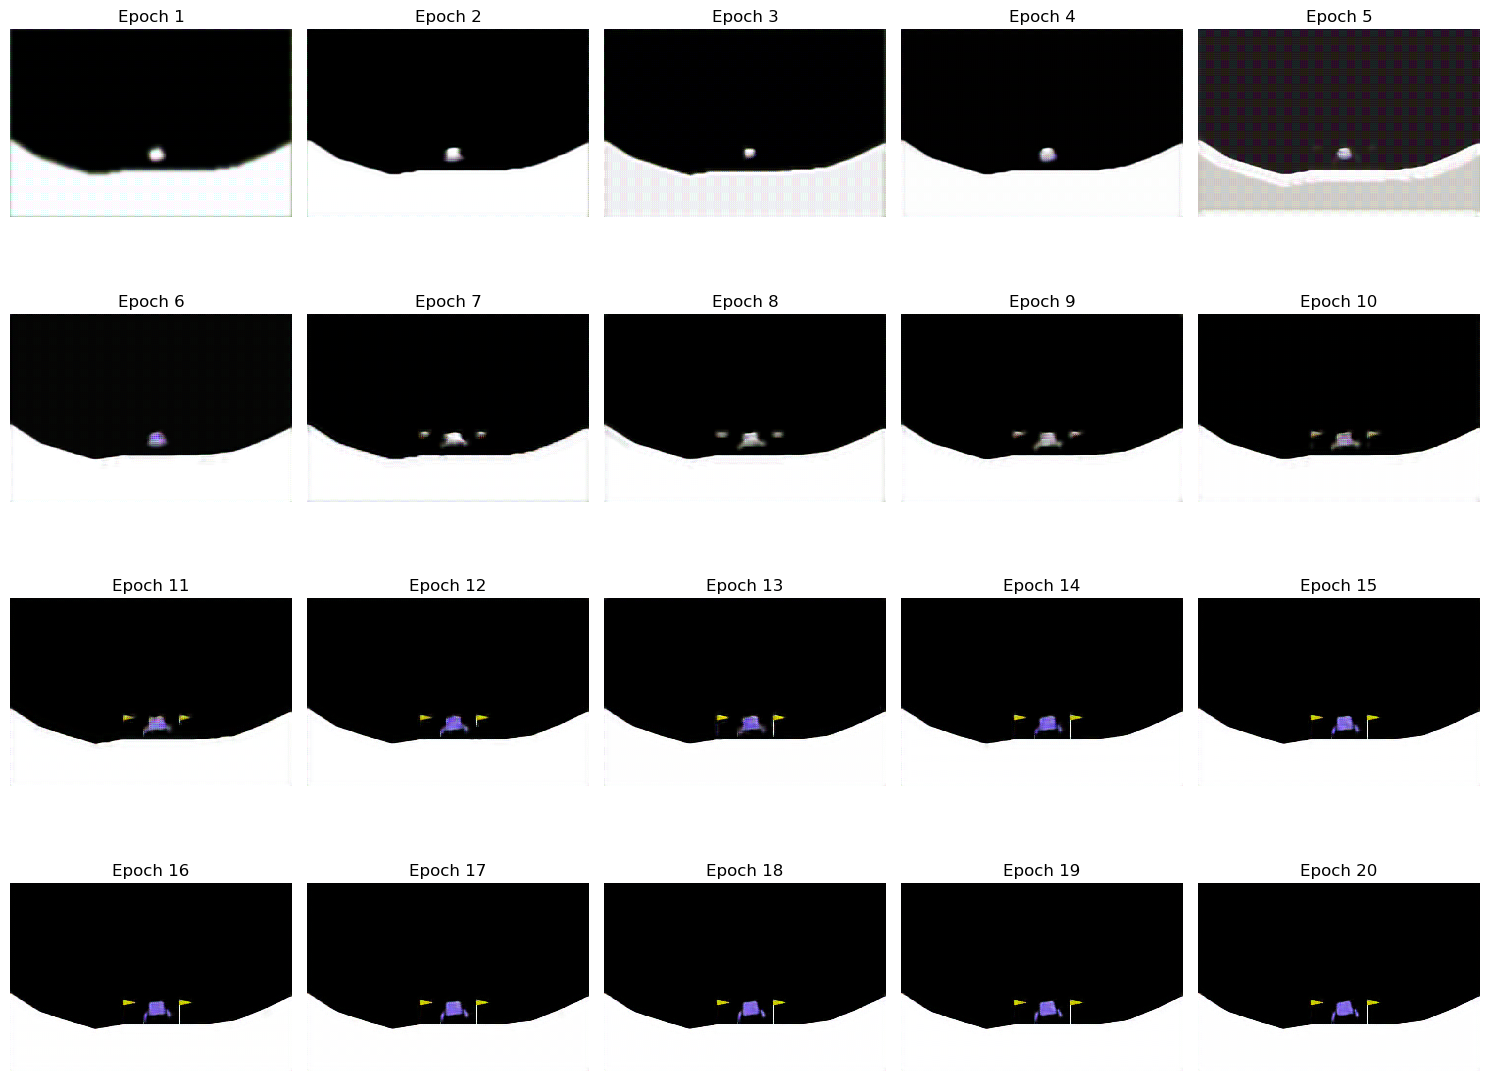

In [21]:
# Prepare validation data
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

# Plot original images
plt.figure(figsize=(10, 5))
original_img = make_grid(valid_originals.cpu().data, nrow=7, padding=2) + 0.5
original_npimg = original_img.numpy()
plt.imshow(np.transpose(original_npimg, (1, 2, 0)), interpolation='nearest')
plt.title("Original Image")
plt.axis('off')
plt.show()
models_directory = "Models"  # Replace with the actual path if not in the current working directory
model_paths = [os.path.join(models_directory, f) for f in os.listdir(models_directory) if os.path.isfile(os.path.join(models_directory, f))]
# Number of models
n_models = len(model_paths)
images_per_row = 5
rows = math.ceil(n_models / images_per_row)

# Set up the figure for the grid of reconstructions
fig, axs = plt.subplots(rows, images_per_row, figsize=(15, rows * 3))
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through models and plot reconstructions
for i, model_path in enumerate(model_paths):
    # Debug: Print current model being loaded
    model = VQModel(num_hiddens, num_residual_layers, num_residual_hiddens,
                  num_embeddings, embedding_dim,
                  commitment_cost, decay).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    
    # Generate reconstructions
    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    
    # Plot reconstructions
    recon_img = make_grid(valid_reconstructions.cpu().data, nrow=7, padding=2) + 0.5
    recon_npimg = np.clip(recon_img.numpy(), 0, 1)
    #recon_npimg = recon_img.numpy()
    axs[i].imshow(np.transpose(recon_npimg, (1, 2, 0)), interpolation='nearest')
    axs[i].set_title(f"Epoch {i+1}")  # Adjust title as needed
    axs[i].axis('off')

# Hide unused subplots if n_models is not a multiple of images_per_row
for j in range(n_models, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()
